In [ ]:
!nvidia-smi

Fri Mar 15 08:12:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              28W /  70W |    949MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
pip install supervision


In [ ]:
pip install easyocr

In [ ]:
pip install ultralytics

In [ ]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque



<ipython-input-74-3f0499949abe>:59: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)


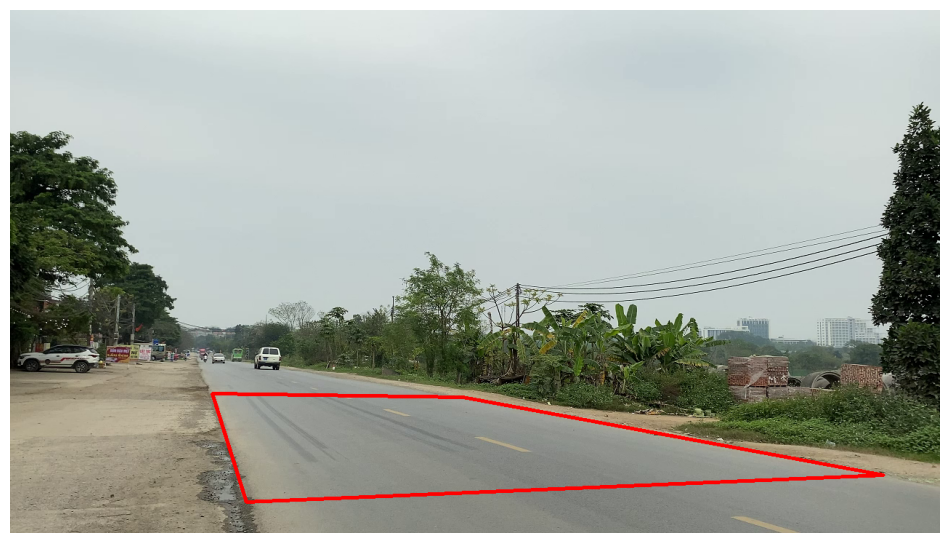

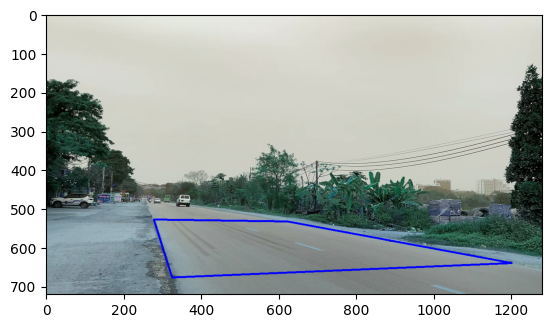

In [ ]:
import cv2


import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

from google.colab.patches import cv2_imshow


SOURCE_VIDEO_PATH = "/content/hoalac3.mp4"
# SOURCE_VIDEO_PATH = cv2.VideoCapture(0)
# SOURCE_VIDEO_PATH.set(cv2.CAP_PROP_FRAME_WIDTH,720)
# SOURCE_VIDEO_PATH.set(cv2.CAP_PROP_FRAME_HEIGHT,480)
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
# MODEL_NAME = "visdrone_yolov8s.pt"
MODEL_RESOLUTION = 1720


frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)
annotated_frame = frame.copy()



# SOURCE = np.array([
#     [270, 540],
#     [500, 510],
#     [1000, 600],
#     [330, 717]
# ])

SOURCE = np.array([
    [278, 528],
    [623, 533],
    [1202, 640],
    [325, 677]
])

TARGET_WIDTH = 7
TARGET_HEIGHT = 20

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])



annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)


import matplotlib.pyplot as plt
plt.imshow(annotated_frame)

In [ ]:




class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

view_transformer = ViewTransformer(source=SOURCE, target=TARGET)
model = YOLO('visdrone_yolov8s.pt')
names = model.model.names
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_thresh=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = sv.calculate_dynamic_line_thickness(
    resolution_wh=video_info.resolution_wh
)
text_scale = sv.calculate_dynamic_text_scale(
    resolution_wh=video_info.resolution_wh
)
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
target_line = False
# open target video

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    over_speed_frame = []
    car_pos = []
    tracker_list = []
    store_car_and_pos = dict()
    car_list_post = []
    car_speed = []
    count= 0
    all_car = []
    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        #clss = result[0].boxes.cls.cpu().tolist()

        for r in result:
          for c in r.boxes.cls:
            probs=names[int(c)]
        #probs = result.probs
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)
        # format labels
        labels = []
        #cls_name=names[(clss)]
        a =   detections.tracker_id

        for tracker_id in detections.tracker_id:
            # print(detections.tracker_id)

            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"In coming")
            else:


                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                if tracker_id not in all_car:
                  all_car.append(tracker_id)
                  count += 1
                if int(speed) >40:
                    a = detections.tracker_id
                    labels.append(f"{int(speed)} km/h is overspeed")
                    if tracker_id not in tracker_list:
                      tracker_list.append(tracker_id)
                      over_speed_frame.append(frame)
                      pos = np.where(a==tracker_id)[0][0]
                      car_list_post.append(detections.xyxy[pos])
                      car_pos.append(pos)
                      car_speed.append(int(speed))
                      # print(detections.xyxy[pos])


                    # cropped_image = sv.crop_image(image=frame, xyxy=detections.xyxy[pos])
                    # sv.plot_image(cropped_image)
                else:
                    labels.append(f"{int(speed)} km/h")
        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )
        text_anchor = Point(x=200, y=50)
        sv.draw_text(annotated_frame, text="count "+ str(count), text_anchor=text_anchor,text_color=sv.Color.GREEN ,text_scale=1,text_thickness = 3)
        sink.write_frame(annotated_frame)





  0%|          | 0/319 [00:00<?, ?it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  0%|          | 1/319 [00:00<02:16,  2.32it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  1%|          | 3/319 [00:00<00:52,  6.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  2%|▏         | 5/319 [00:00<00:35,  8.85it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  2%|▏         | 7/319 [00:00<00:28, 10.85it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  3%|▎         | 9/319 [00:00<00:24, 12.58it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  3%|▎         | 11/319 [00:01<00:22, 13.64it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  4%|▍         | 13/319 [00:01<00:21, 14.45it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  5%|▍         | 15/319 [00:01<00:20, 14.97it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  5%|▌         | 17/319 [00:01<00:19, 15.55it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  6%|▌         | 19/319 [00:01<00:18, 15.94it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  7%|▋         | 21/319 [00:01<00:18, 16.37it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  7%|▋         | 23/319 [00:01<00:17, 16.48it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  8%|▊         | 25/319 [00:01<00:17, 16.58it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  8%|▊         | 27/319 [00:02<00:17, 16.62it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


  9%|▉         | 29/319 [00:02<00:17, 16.69it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 10%|▉         | 31/319 [00:02<00:17, 16.78it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 10%|█         | 33/319 [00:02<00:17, 16.82it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 11%|█         | 35/319 [00:02<00:16, 16.98it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 12%|█▏        | 37/319 [00:02<00:16, 16.99it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 12%|█▏        | 39/319 [00:02<00:16, 17.05it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 13%|█▎        | 41/319 [00:02<00:16, 17.00it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 13%|█▎        | 43/319 [00:02<00:16, 17.06it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 14%|█▍        | 45/319 [00:03<00:16, 17.11it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 15%|█▍        | 47/319 [00:03<00:15, 17.23it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 15%|█▌        | 49/319 [00:03<00:15, 17.19it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 16%|█▌        | 51/319 [00:03<00:15, 17.06it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 17%|█▋        | 53/319 [00:03<00:15, 16.96it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 17%|█▋        | 55/319 [00:03<00:15, 17.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 18%|█▊        | 57/319 [00:03<00:16, 16.12it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 18%|█▊        | 59/319 [00:03<00:16, 15.31it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 19%|█▉        | 61/319 [00:04<00:17, 14.97it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 20%|█▉        | 63/319 [00:04<00:17, 14.68it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 20%|██        | 65/319 [00:04<00:17, 14.53it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 21%|██        | 67/319 [00:04<00:17, 14.55it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 22%|██▏       | 69/319 [00:04<00:17, 14.43it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 22%|██▏       | 71/319 [00:04<00:17, 14.49it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 23%|██▎       | 73/319 [00:04<00:17, 14.38it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 24%|██▎       | 75/319 [00:05<00:17, 13.99it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 24%|██▍       | 77/319 [00:05<00:16, 14.37it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 25%|██▍       | 79/319 [00:05<00:16, 14.34it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 25%|██▌       | 81/319 [00:05<00:16, 14.47it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 26%|██▌       | 83/319 [00:05<00:16, 14.12it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 27%|██▋       | 85/319 [00:05<00:17, 13.70it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 27%|██▋       | 87/319 [00:05<00:16, 13.93it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 28%|██▊       | 89/319 [00:06<00:15, 14.73it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 29%|██▊       | 91/319 [00:06<00:14, 15.25it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 29%|██▉       | 93/319 [00:06<00:14, 15.69it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 30%|██▉       | 95/319 [00:06<00:13, 16.19it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 30%|███       | 97/319 [00:06<00:13, 16.26it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 31%|███       | 99/319 [00:06<00:13, 16.49it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 32%|███▏      | 101/319 [00:06<00:13, 16.65it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 32%|███▏      | 103/319 [00:06<00:12, 16.82it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 33%|███▎      | 105/319 [00:06<00:12, 16.67it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 34%|███▎      | 107/319 [00:07<00:12, 16.76it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 34%|███▍      | 109/319 [00:07<00:12, 16.89it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 35%|███▍      | 111/319 [00:07<00:12, 16.98it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 35%|███▌      | 113/319 [00:07<00:11, 17.20it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 36%|███▌      | 115/319 [00:07<00:11, 17.19it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 37%|███▋      | 117/319 [00:07<00:11, 17.17it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 37%|███▋      | 119/319 [00:07<00:11, 17.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 38%|███▊      | 121/319 [00:07<00:11, 17.02it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 39%|███▊      | 123/319 [00:08<00:11, 16.80it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 39%|███▉      | 125/319 [00:08<00:11, 16.69it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 40%|███▉      | 127/319 [00:08<00:11, 16.90it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 40%|████      | 129/319 [00:08<00:11, 17.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 41%|████      | 131/319 [00:08<00:11, 16.99it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 42%|████▏     | 133/319 [00:08<00:10, 16.94it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 42%|████▏     | 135/319 [00:08<00:10, 17.03it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 43%|████▎     | 137/319 [00:08<00:10, 17.11it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 44%|████▎     | 139/319 [00:09<00:10, 16.75it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 44%|████▍     | 141/319 [00:09<00:10, 16.91it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 45%|████▍     | 143/319 [00:09<00:10, 16.95it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 45%|████▌     | 145/319 [00:09<00:10, 16.84it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 46%|████▌     | 147/319 [00:09<00:10, 17.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 47%|████▋     | 149/319 [00:09<00:09, 17.06it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 47%|████▋     | 151/319 [00:09<00:09, 16.97it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 48%|████▊     | 153/319 [00:09<00:09, 17.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 49%|████▊     | 155/319 [00:09<00:09, 17.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 49%|████▉     | 157/319 [00:10<00:09, 16.97it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 50%|████▉     | 159/319 [00:10<00:09, 17.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 50%|█████     | 161/319 [00:10<00:09, 17.02it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 51%|█████     | 163/319 [00:10<00:09, 16.95it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 52%|█████▏    | 165/319 [00:10<00:09, 16.81it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 52%|█████▏    | 167/319 [00:10<00:09, 16.79it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 53%|█████▎    | 169/319 [00:10<00:08, 16.86it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 54%|█████▎    | 171/319 [00:10<00:08, 16.98it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 54%|█████▍    | 173/319 [00:11<00:08, 16.96it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 55%|█████▍    | 175/319 [00:11<00:08, 16.81it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 55%|█████▌    | 177/319 [00:11<00:08, 16.91it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 56%|█████▌    | 179/319 [00:11<00:08, 16.97it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 57%|█████▋    | 181/319 [00:11<00:08, 16.95it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 57%|█████▋    | 183/319 [00:11<00:08, 16.87it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 58%|█████▊    | 185/319 [00:11<00:07, 16.99it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 59%|█████▊    | 187/319 [00:11<00:07, 17.00it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 59%|█████▉    | 189/319 [00:11<00:07, 17.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 60%|█████▉    | 191/319 [00:12<00:07, 16.99it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 61%|██████    | 193/319 [00:12<00:07, 16.89it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 61%|██████    | 195/319 [00:12<00:07, 16.72it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 62%|██████▏   | 197/319 [00:12<00:07, 16.73it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 62%|██████▏   | 199/319 [00:12<00:07, 16.77it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 63%|██████▎   | 201/319 [00:12<00:07, 16.66it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 64%|██████▎   | 203/319 [00:12<00:07, 16.52it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 64%|██████▍   | 205/319 [00:12<00:06, 16.38it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 65%|██████▍   | 207/319 [00:13<00:06, 16.40it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 66%|██████▌   | 209/319 [00:13<00:06, 16.15it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 66%|██████▌   | 211/319 [00:13<00:06, 16.27it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 67%|██████▋   | 213/319 [00:13<00:06, 16.16it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 67%|██████▋   | 215/319 [00:13<00:06, 16.00it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 68%|██████▊   | 217/319 [00:13<00:06, 15.88it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 69%|██████▊   | 219/319 [00:13<00:06, 16.00it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 69%|██████▉   | 221/319 [00:13<00:06, 16.02it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 70%|██████▉   | 223/319 [00:14<00:05, 16.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 71%|███████   | 225/319 [00:14<00:05, 16.02it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 71%|███████   | 227/319 [00:14<00:05, 16.05it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 72%|███████▏  | 229/319 [00:14<00:05, 16.22it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 72%|███████▏  | 231/319 [00:14<00:05, 16.41it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 73%|███████▎  | 233/319 [00:14<00:05, 16.59it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 74%|███████▎  | 235/319 [00:14<00:05, 16.57it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 74%|███████▍  | 237/319 [00:14<00:04, 16.44it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 75%|███████▍  | 239/319 [00:15<00:04, 16.50it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 76%|███████▌  | 241/319 [00:15<00:04, 16.35it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 76%|███████▌  | 243/319 [00:15<00:04, 16.09it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 77%|███████▋  | 245/319 [00:15<00:04, 16.00it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 77%|███████▋  | 247/319 [00:15<00:04, 16.19it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 78%|███████▊  | 249/319 [00:15<00:04, 16.32it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 79%|███████▊  | 251/319 [00:15<00:04, 16.50it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 79%|███████▉  | 253/319 [00:15<00:04, 16.44it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 80%|███████▉  | 255/319 [00:16<00:04, 15.65it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 81%|████████  | 257/319 [00:16<00:04, 15.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 81%|████████  | 259/319 [00:16<00:04, 14.54it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 82%|████████▏ | 261/319 [00:16<00:04, 14.17it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 82%|████████▏ | 263/319 [00:16<00:03, 14.07it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 83%|████████▎ | 265/319 [00:16<00:03, 14.09it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 84%|████████▎ | 267/319 [00:16<00:03, 14.30it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 84%|████████▍ | 269/319 [00:17<00:03, 14.47it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 85%|████████▍ | 271/319 [00:17<00:03, 14.42it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 86%|████████▌ | 273/319 [00:17<00:03, 14.16it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 86%|████████▌ | 275/319 [00:17<00:03, 14.15it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 87%|████████▋ | 277/319 [00:17<00:02, 14.24it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 87%|████████▋ | 279/319 [00:17<00:02, 13.77it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 88%|████████▊ | 281/319 [00:17<00:02, 13.72it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 89%|████████▊ | 283/319 [00:18<00:02, 13.44it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 89%|████████▉ | 285/319 [00:18<00:02, 13.71it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 90%|████████▉ | 287/319 [00:18<00:02, 14.19it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 91%|█████████ | 289/319 [00:18<00:02, 14.55it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 91%|█████████ | 291/319 [00:18<00:01, 14.89it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 92%|█████████▏| 293/319 [00:18<00:01, 15.29it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 92%|█████████▏| 295/319 [00:18<00:01, 15.57it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 93%|█████████▎| 297/319 [00:18<00:01, 15.84it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 94%|█████████▎| 299/319 [00:19<00:01, 16.03it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 94%|█████████▍| 301/319 [00:19<00:01, 16.13it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 95%|█████████▍| 303/319 [00:19<00:01, 15.88it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 96%|█████████▌| 305/319 [00:19<00:00, 15.81it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 96%|█████████▌| 307/319 [00:19<00:00, 15.87it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 97%|█████████▋| 309/319 [00:19<00:00, 16.01it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 97%|█████████▋| 311/319 [00:19<00:00, 16.06it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 98%|█████████▊| 313/319 [00:19<00:00, 16.14it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 99%|█████████▊| 315/319 [00:20<00:00, 16.26it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


 99%|█████████▉| 317/319 [00:20<00:00, 16.39it/s]

WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]
WARNING ⚠️ imgsz=[1720] must be multiple of max stride 32, updating to [1728]


100%|██████████| 319/319 [00:20<00:00, 15.72it/s]


In [ ]:
class ImageSink:
    def __init__(
        self,
        target_dir_path: str,
        overwrite: bool = False,
        image_name_pattern: str = "image_{:05d}.png",
    ):
        """
        Initialize a context manager for saving images.

        Args:
            target_dir_path (str): The target directory where images will be saved.
            overwrite (bool, optional): Whether to overwrite the existing directory.
                Defaults to False.
            image_name_pattern (str, optional): The image file name pattern.
                Defaults to "image_{:05d}.png".

        Examples:
            ```python
            import supervision as sv

            with sv.ImageSink(target_dir_path='target/directory/path',
                              overwrite=True) as sink:
                for image in sv.get_video_frames_generator(
                    source_path='source_video.mp4', stride=2):
                    sink.save_image(image=image)
            ```
        """

        self.target_dir_path = target_dir_path
        self.overwrite = overwrite
        self.image_name_pattern = image_name_pattern
        self.image_count = 0

    def __enter__(self):
        if os.path.exists(self.target_dir_path):
            if self.overwrite:
                shutil.rmtree(self.target_dir_path)
                os.makedirs(self.target_dir_path)
        else:
            os.makedirs(self.target_dir_path)

        return self

    def save_image(self, image: np.ndarray, image_name = None):
        """
        Save a given image in the target directory.

        Args:
            image (np.ndarray): The image to be saved.
            image_name (str, optional): The name to use for the saved image.
                If not provided, a name will be
                generated using the `image_name_pattern`.
        """
        if image_name is None:
            image_name = self.image_name_pattern.format(self.image_count)

        image_path = os.path.join(self.target_dir_path, image_name)
        cv2.imwrite(image_path, image)
        self.image_count += 1

    def __exit__(self, exc_type, exc_value, exc_traceback):
        pass

In [ ]:
for i in car_list_post:
  print(i)

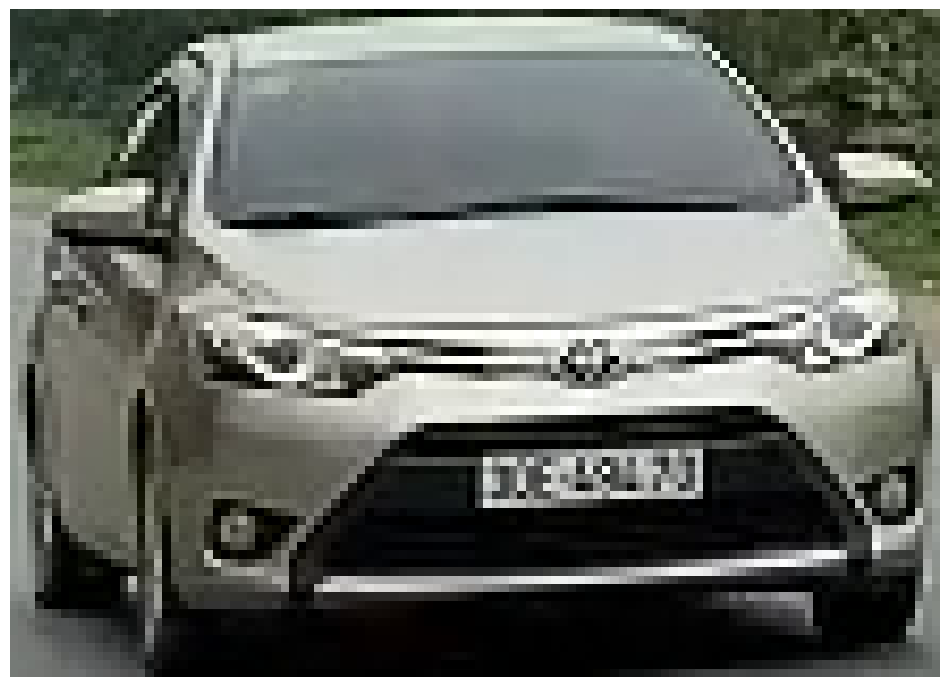

In [ ]:



with sv.ImageSink(target_dir_path='D:\3_DAP391m',
                              overwrite=True) as sink:
                count = 0
for f in over_speed_frame:
  cropped_image = sv.crop_image(image=f, xyxy=car_list_post[count])
  count +=1
  sv.plot_image(cropped_image)
  sink.save_image(image=cropped_image)





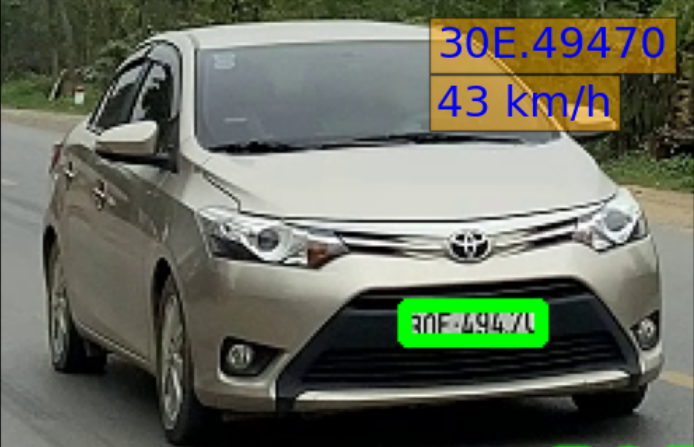

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import glob
from google.colab.patches import cv2_imshow
image_paths = glob.glob('/content/D:_DAP391m/*.png')
path = r'/content/Screenshot 2024-03-07 133544.png'
image = cv2.imread(path)
window_name = 'Licence capture'
cv2_imshow( image)
cv2.destroyAllWindows()
def print_lisence_plate(path,speed):
  count = 0
  for image in path:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) #Edge detection
    # plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break


    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)

    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)
    result
    try:
      text = result[0][-2]

      font = cv2.FONT_HERSHEY_SIMPLEX
      res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
      res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)

      plt.text(150, 20, text, fontsize = 22,color= 'blue',bbox = dict(facecolor = 'orange', alpha = 0.5))
      plt.text(150, 40, str(car_speed[count]) +' km/h', fontsize = 22,color= 'blue',bbox = dict(facecolor = 'orange', alpha = 0.5))
      plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    except:
      continue
    count += 1


# print_lisence_plate(image_paths,speed)


In [ ]:
import  io
# from painter import Visualizer
from RRDBNet import RRDBNet# we use RRDB in this demo
import tensorflow as tf
# import  matplotlib as plt
import glob
import matplotlib.pyplot as plt
import numpy as np
"""
a simple script to visualize and compare the ground truth, downsampled input image, and model prediction
"""


class Visualizer:

    def plot(self, x, y, yPred=None):
        x = np.squeeze(np.clip(x, a_min=0, a_max=1))
        y = np.squeeze(np.clip(y, a_min=0, a_max=1))
        if yPred is None:
            picNum = 2
        else:
            picNum = 3
            yPred = np.squeeze(np.clip(yPred, a_min=0, a_max=1))
        fig, ax = plt.subplots(1, picNum)
        fig.set_size_inches(8, 8)
        ax[0].imshow(x)
        ax[0].set_title('input image')
        ax[1].imshow(y)
        ax[1].set_title('ground truth')
        if yPred is not None:
            ax[2].imshow(yPred)
            ax[2].set_title('recovered')
class DataLoader:
    def __init__(self, scale=2):
        self.scale = scale
    """
    Load an image from disk and return it as a tensor
    """
    def decodeImg(self, path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        #image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.adjust_contrast(image, 0.7)
        return image, tf.shape(image)
    """
    preprocess the image to create labels
    """
    def processXY(self, path):
        y, size = self.decodeImg(path)
        x = tf.image.resize(y, [size[0]/self.scale, size[1]/self.scale])

        return x, y

    def load(self, fileList, batchSize=24):
        fileList = tf.data.Dataset.from_tensor_slices(fileList)
        data = fileList.map(self.processXY, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        # repeat forever, requires explicit epoch control in the training script
        data = data.batch(batchSize).repeat()
        data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return data


DATA_PATH = 'Samples'
loader = DataLoader()
data = loader.load(glob.glob(DATA_PATH + '/*.png'), batchSize=1)
painter = Visualizer()
# for downSample, original in data.take(1):
#     painter.plot(downSample, original)

# pretrained rrdb network can be found in the Pretrained folder
MODEL_PATH = 'Pretrained/rrdb'
model = RRDBNet(blockNum=10)
model.load_weights(MODEL_PATH)


for downSample, original in data.take(2):
    yPred = model.predict(original)

    painter.plot( downSample, yPred, )
    plt.show()


